# Experiments - Part 1
## Based on Luz Rello, et al., (2020) **Predicting risk of dyslexia with an online gamified test**

* Program name: Master's in Computer Science - Artificial Intelligence (MAI)
* Student name: Kostadin Georgiev
* Student Id: 22229358

In [44]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE, ADASYN

%matplotlib inline

## Experiments

In [3]:
# Exctract name of columns
features = pd.read_csv('data/Dyt-desktop.csv', delimiter=';').columns.values[:-1]

def load_data(path):
    data = pd.read_csv(path, delimiter=';')

    # Extract data points (features) as a NumPy array
    X = data.iloc[:, :-1].values

    # Extract labels as a NumPy array
    y = data['Dyslexia'].values
    y = np.where(y == 'Yes', 1, 0)

    return X, y

def pre_process(data, labels):
    X, y = data, labels

    # Replace NaN values with 0s
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i][j] = np.nan_to_num(X[i][j])

    # Encode 'Male' to 0 and 'Female' to 1
    X[:, 0] = np.where(X[:, 0] == 'Male', 0, 1)

    # Encode 'Yes' to 1 and 'No' to 0
    X[:, 1] = np.where(X[:, 1] == 'Yes', 1, 0)
    X[:, 2] = np.where(X[:, 2] == 'Yes', 1, 0)

    # Perform Min-Max scaling for non-'Accuracy' columns
    scaler = MinMaxScaler(feature_range=(0, 1))
    for i, feature in enumerate(features):
        if not feature.startswith('Accuracy'):
            column_values = X[:, i].astype(float).reshape(-1, 1)
            X[:, i] = scaler.fit_transform(column_values).flatten()
    
    return X, y

def cross_validate(X, y, create_model, n_folds=10, threshold=0.5, seed=42, oversampling=None):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    accuracies = []
    recalls = []
    precisions = []
    rocs = []
    f1_scores = []
    
    for train, test in kf.split(X):
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]

        if oversampling == 'smote':
            oversampler = SMOTE(random_state=seed)
        if oversampling == 'adasyn':
            oversampler = ADASYN(random_state=seed)
        if oversampling is not None:
            X_train, y_train = oversampler.fit_resample(X_train, y_train)

        model = create_model(seed=seed)
        model.fit(X_train, y_train)

        predicted_probabilities = model.predict_proba(X_test)
        y_pred = (predicted_probabilities[:, 1] >= threshold).astype(int)

        accuracy = metrics.accuracy_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0)
        precision = metrics.precision_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0)
        roc_score = metrics.roc_auc_score(y_test, y_pred)
        f1_score = metrics.f1_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0)
        
        accuracies.append(accuracy)
        recalls.append(recall)
        precisions.append(precision)
        rocs.append(roc_score)
        f1_scores.append(f1_score)
    
    accuracy = float("{:.1f}".format(np.mean(accuracies) * 100))
    recall = float("{:.1f}".format(np.mean(recalls) * 100))
    precision = float("{:.1f}".format(np.mean(precisions) * 100))
    roc = float("{:.3f}".format(np.mean(rocs)))
    f1_score = float("{:.1f}".format(np.mean(f1_scores) * 100))

    return accuracy, recall, precision, roc, f1_score

def run_experiment(X, y, create_model, threshold=0.5, oversampling=None, seed=42):
    results = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'ROC', 'F1 Score', 'Threshold'])
    accuracy, recall, precision, roc, f1_score = cross_validate(X, y, create_model, threshold=threshold, seed=seed, oversampling=oversampling)
    results.loc[0] = [accuracy, recall, precision, roc, f1_score, "{:.3f}".format(threshold)]

    return results

def rf_200_balanced(seed=42):
    return RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=seed)

def rf_200_unbalanced(seed=42):
    return RandomForestClassifier(n_estimators=200, class_weight=None, random_state=seed)

In [4]:
data, labels = load_data('data/Dyt-desktop.csv')
data, labels = pre_process(data, labels)

### Experiment 1: Baseline Model

In [5]:
result_exp_01 = run_experiment(data, labels, rf_200_balanced, threshold=0.115, oversampling=None, seed=42)
result_exp_01

,Accuracy,Recall,Precision,ROC,F1 Score,Threshold
0,76.8,80.0,29.1,0.782,42.4,0.115


### Experiment 2: Unbalanced Classes

In [6]:
result_exp_02 = run_experiment(data, labels, rf_200_unbalanced, oversampling=None, seed=42)
result_exp_02

,Accuracy,Recall,Precision,ROC,F1 Score,Threshold
0,90.0,10.2,75.0,0.549,17.7,0.500


### Experiment 3: Class Balancing

In [7]:
result_exp_03 = run_experiment(data, labels, rf_200_balanced, oversampling=None, seed=42)
result_exp_03

,Accuracy,Recall,Precision,ROC,F1 Score,Threshold
0,89.6,4.6,75.8,0.522,8.6,0.500


### Experiment 4: SMOTE

In [8]:
result_exp_04 = run_experiment(data, labels, rf_200_unbalanced, oversampling='smote', seed=42)
result_exp_04

,Accuracy,Recall,Precision,ROC,F1 Score,Threshold
0,90.8,24.4,70.9,0.616,36.0,0.500


### Experiment 5: ADASYN

In [9]:
result_exp_05 = run_experiment(data, labels, rf_200_unbalanced, oversampling='adasyn', seed=42)
result_exp_05

,Accuracy,Recall,Precision,ROC,F1 Score,Threshold
0,90.7,25.0,69.5,0.618,36.1,0.500


### Experiment 6: K-Nearest Neighbors

In [10]:
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='f1')
grid_search.fit(data, labels)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Best Score: 0.2468391342291527


In [11]:
def knn_1(seed=42):
    return KNeighborsClassifier(n_neighbors=1, weights='uniform', metric='manhattan')

In [12]:
result_exp_06 = run_experiment(data, labels, knn_1, oversampling='smote', seed=42)
result_exp_06

,Accuracy,Recall,Precision,ROC,F1 Score,Threshold
0,80.8,34.7,23.4,0.605,27.7,0.500


### Experiment 7: Support Vector Machine

In [13]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1]
}

svc = SVC(kernel='rbf', probability=True, random_state=42)
grid_search = GridSearchCV(svc, param_grid, cv=10, scoring='f1')
grid_search.fit(data, labels)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 100, 'gamma': 0.1}
Best Score: 0.33744349377819655


In [14]:
def svm_100_001(seed=42):
    return SVC(C=100, kernel='rbf', gamma=0.01, probability=True, random_state=42)

In [15]:
result_exp_07 = run_experiment(data, labels, svm_100_001, oversampling='smote', seed=42)
result_exp_07

,Accuracy,Recall,Precision,ROC,F1 Score,Threshold
0,86.2,49.9,39.2,0.702,43.8,0.500


## Compare Results

In [49]:
experiments = [result_exp_01, result_exp_02, result_exp_03, result_exp_04, result_exp_05, result_exp_06, result_exp_07]
experiment_names = [
    'EXP01: Baseline Model',
    'EXP02: Random Forest w/o Class Balancing',
    'EXP03: Random Forest with Class Balancing',
    'EXP04: Random Forest with SMOTE',
    'EXP05: Random Forest with ADASYN',
    'EXP06: K-Nearest Neighbors with SMOTE',
    'EXP07: Support Vector Machine with SMOTE'
]
results = pd.concat(experiments, ignore_index=True)
results = results.astype(float)
results.insert(0, 'Experiment', experiment_names)
results.to_csv('./results/results_1.csv')
results

,Experiment,Accuracy,Recall,Precision,ROC,F1 Score,Threshold
0,EXP01: Baseline Model,76.8,80.0,29.1,0.782,42.4,0.115
1,EXP02: Random Forest w/o Class Balancing,90.0,10.2,75.0,0.549,17.7,0.500
2,EXP03: Random Forest with Class Balancing,89.6,4.6,75.8,0.522,8.6,0.500
3,EXP04: Random Forest with SMOTE,90.8,24.4,70.9,0.616,36.0,0.500
4,EXP05: Random Forest with ADASYN,90.7,25.0,69.5,0.618,36.1,0.500
5,EXP06: K-Nearest Neighbors with SMOTE,80.8,34.7,23.4,0.605,27.7,0.500
6,EXP07: Support Vector Machine with SMOTE,86.2,49.9,39.2,0.702,43.8,0.500


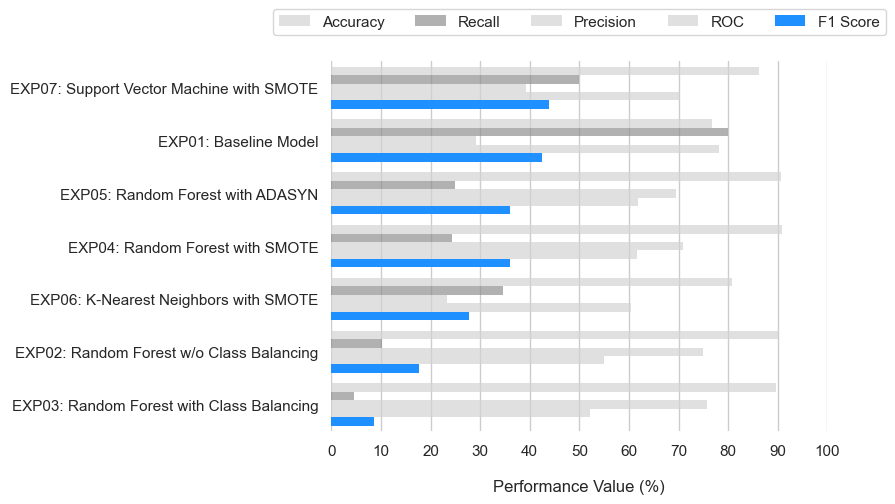

In [52]:
results_sorted = results.sort_values(by='F1 Score', ascending=False)
results_sorted['ROC'] = results_sorted['ROC'].apply(lambda x: x*100)
results_sorted = results_sorted.drop('Threshold', axis=1)
melted_df = pd.melt(results_sorted, id_vars='Experiment', var_name='Metric', value_name='Value')
ax = sns.barplot(data=melted_df, x='Value', y='Experiment', hue='Metric', dodge=True, linewidth=0)

sns.set(style='whitegrid')
colors = {'Accuracy': 'lightgrey', 'Recall': '#909090', 'Precision': 'lightgrey', 'ROC': 'lightgrey', 'F1 Score': 'dodgerblue'}

for metric, color in colors.items():
    for bar in ax.containers:
        if metric in bar.get_label():
            for rect in bar:
                alpha = 0.7 if metric != 'F1 Score' else 1.0
                for rect in bar:
                    rect.set_color(color)
                    rect.set_alpha(alpha)

plt.xlabel('Performance Value (%)', labelpad=15)
plt.ylabel('')
plt.legend(title='', bbox_to_anchor=(0.5, 1.05), loc='lower center', ncol=5)

plt.xticks(np.arange(0, 101, 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

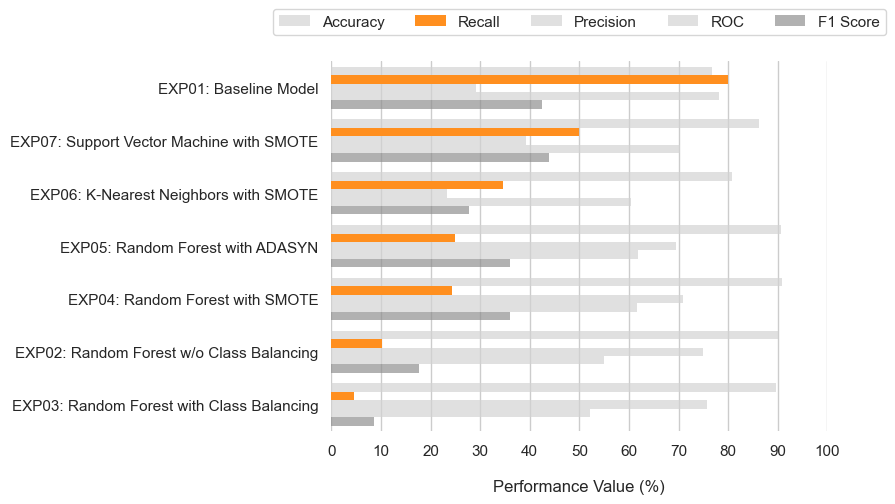

In [41]:
results_sorted = results.sort_values(by='Recall', ascending=False)
results_sorted['ROC'] = results_sorted['ROC'].apply(lambda x: x*100)
results_sorted = results_sorted.drop('Threshold', axis=1)
melted_df = pd.melt(results_sorted, id_vars='Experiment', var_name='Metric', value_name='Value')
ax = sns.barplot(data=melted_df, x='Value', y='Experiment', hue='Metric', dodge=True, linewidth=0)

sns.set(style='whitegrid')
colors = {'Accuracy': 'lightgrey', 'Recall': '#FF8F1F', 'Precision': 'lightgrey', 'ROC': 'lightgrey', 'F1 Score': '#909090'}

for metric, color in colors.items():
    for bar in ax.containers:
        if metric in bar.get_label():
            for rect in bar:
                alpha = 0.7 if metric != 'Recall' else 1.0
                for rect in bar:
                    rect.set_color(color)
                    rect.set_alpha(alpha)

plt.xlabel('Performance Value (%)', labelpad=15)
plt.ylabel('')
plt.legend(title='', bbox_to_anchor=(0.5, 1.05), loc='lower center', ncol=5)

plt.xticks(np.arange(0, 101, 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()